In [223]:

from box import Box


args = Box()
# args.checkpoint_path = 'ztmp/checkpoint_1ep.pth.tar'
# args.checkpoint_path = 'ztmp/checkpoint_10ep.pth.tar'
# args.checkpoint_path = 'ztmp/27kpng_model_best.pth.tar'
args.checkpoint_path = 'ztmp/checkpoint_finetune_93ep.pth.tar'
args.device = 'cpu'

In [224]:
import torch
import scripts.models as archs

checkpoint = torch.load(args.checkpoint_path, map_location=torch.device(args.device))
model = archs.__dict__[checkpoint['arch']]()
model.load_state_dict(checkpoint['state_dict'])

model.eval()


import torchvision.transforms as transforms
trans = transforms.Compose(
            [
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ]
        )

C:\Users\vutha\AppData\Local\Temp\ipykernel_19332\139120070.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.checkpoint_path, map_location=to

In [225]:
checkpoint.keys()
checkpoint['optimizer']

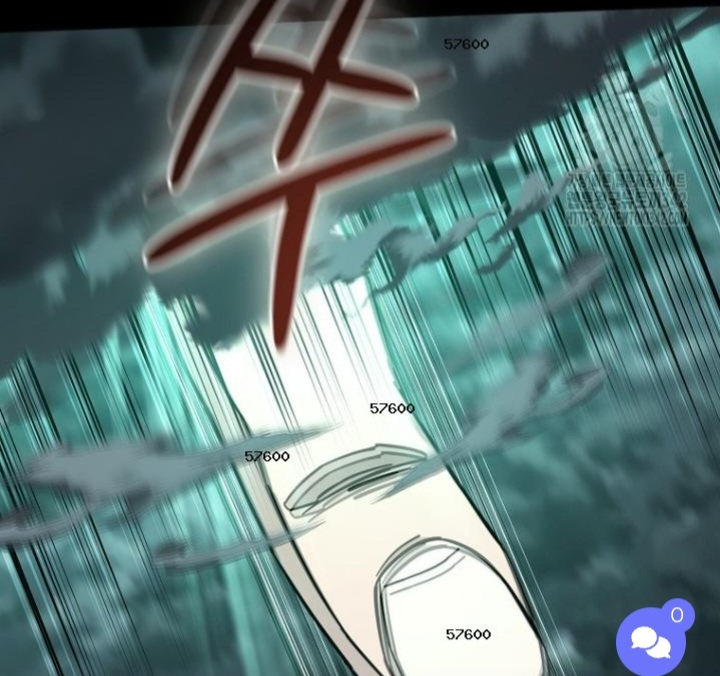

In [234]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import os

test_img = "D:/Projects/WR-comic/tmp/client_ann/Cmanga/raw/2_(93).jpg"
# test_img = "D:/Projects/WR-comic/tmp/client_ann/G5/raw/b_(92).jpg"
# test_img = "D:/Projects/WR-comic/tmp/client_ann/vlog/raw/a_(92).jpg"
# test_img = os.path.join("./data/manhua_ds/val/image/", os.listdir("./data/manhua_ds/val/image/")[5])
# test_img = os.path.join("./data/manhua_ds/train/image/", os.listdir("./data/manhua_ds/train/image/")[5000])
img = Image.open(test_img).convert("RGB")
img

(-32, -32, 224, 224)
(-32, 224, 224, 480)
(-32, 480, 224, 736)
(224, -32, 480, 224)
(224, 224, 480, 480)
(224, 480, 480, 736)
(480, -32, 736, 224)
(480, 224, 736, 480)
(480, 480, 736, 736)


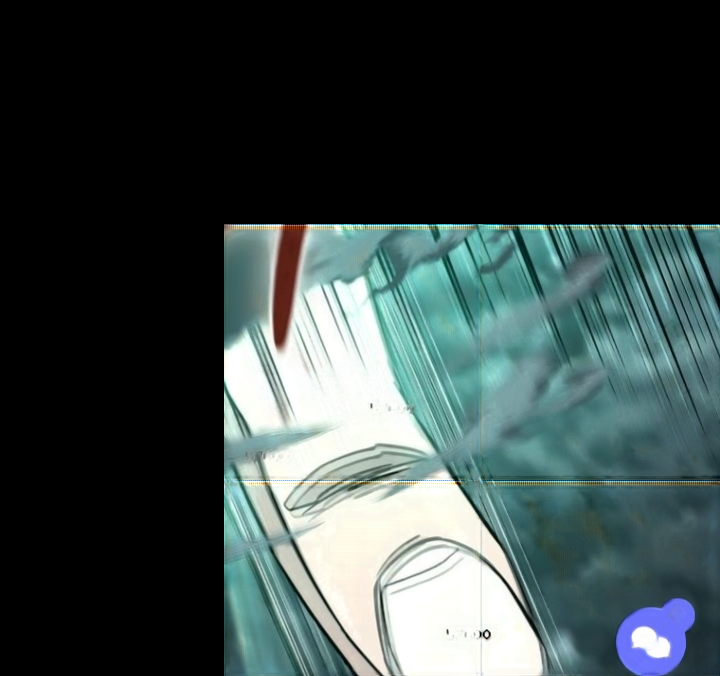

In [360]:
# crop into segments
width, height = img.size
segs = []
poss = []
for i in range(0, width, 256):
    for j in range(0, height, 256):
        pos = (i, j, i + 256, j + 256)
        poss.append(pos)
        seg = img.crop(pos)

        seg = trans(seg)
        # seg = np.array(seg)
        # seg = seg / 255.
        # seg = np.transpose(seg, (2, 0, 1))
        # seg = torch.from_numpy(seg)
        # seg = seg.float().tolist()

        segs.append(seg)
        # break
    # break

# # make batch
## batch = torch.Tensor(segs)
pred_img = []
masks = []
for seg in segs:
    # batch = torch.Tensor([seg])
    batch = seg.unsqueeze(0)
    pred = model(batch)
    # pred_img = pred[0][0].detach().cpu().numpy()
    pred_img.append(pred[0][0].detach().cpu().tolist()[0])
    masks.append(pred[1].detach().cpu().tolist()[0][0])
pred_img = np.array(pred_img)

out_img = np.zeros((3, height, width))
for i, pos in enumerate(poss):
    print(pos)
    _, w, h = out_img[:, pos[1]:pos[3], pos[0]:pos[2]].shape
    seg = pred_img[i][:, :w, :h]
    # clip [0, 1]
    seg = np.clip(seg, 0, 1)
    out_img[:, pos[1]:pos[3], pos[0]:pos[2]] = seg
    # break


out_img = out_img.transpose(1, 2, 0)

out_img = out_img * 255
out_img = out_img.astype(np.uint8)
Image.fromarray(out_img)

# plt.imshow(out_img)
# plt.show()

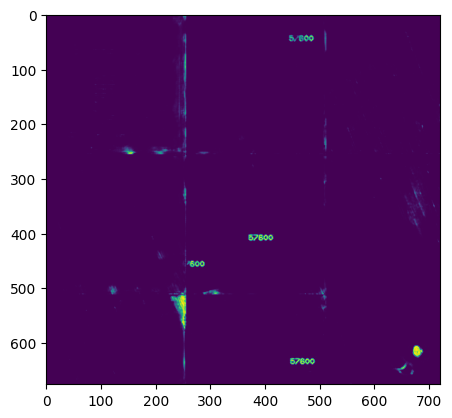

In [236]:
# plt.imshow(pred[1][0][0].detach())
# len(masks)
out_mask = np.zeros((height, width))
for i, pos in enumerate(poss):
    # print(pos)
    w, h = out_mask[pos[1]:pos[3], pos[0]:pos[2]].shape
    seg = np.array(masks[i])[:w, :h]
    # clip [0, 1]
    seg = np.clip(seg, 0, 1)
    out_mask[pos[1]:pos[3], pos[0]:pos[2]] = seg
    # break
plt.imshow(out_mask)
plt.show()

In [91]:
# pred_img[0]
# out_img[:, pos[1]:pos[3], pos[0]:pos[2]].shape
# w, h
# pred_img[i][:, :w, :h].shape

# out_img.shape
# plt.imshow(pred_img[6].transpose(1, 2, 0))

# segs[0].shape
# plt.imshow(segs[0].numpy().transpose(1, 2, 0))

# pred_img[2]
# crop value to [0, 1]


# out_img = out_img.astype(np.uint8)
# Image.fromarray(out_img)

In [14]:
# pred[0][0].shape
# pred[0][1].shape

torch.Size([1, 3, 256, 256])

In [404]:
def split_segments(
    img, 
    patch_size = 256,
    stride = 192,
):
    width, height = img.size

    assert (patch_size - stride) % 2 == 0
    pad = (patch_size - stride) // 2 

    segments = []
    positions = []
    for sx in range(-pad, width+pad, stride):
        for sy in range(-pad, height+pad, stride):
            ex, ey = sx + patch_size, sy + patch_size
            patch = img.crop((sx, sy, ex, ey))
            positions.append((sx, sy, ex, ey))
            segments.append(patch)

    return segments, positions


def reconstruct_image(
    segments,
    positions,
    width,
    height,
    patch_size=256,
    stride=192,
    mode='RGB',
):
    # assert len(segments) == len(positions)
    assert (patch_size - stride) % 2 == 0
    pad = (patch_size - stride) // 2 

    img = Image.new(mode, (width, height))

    for i, (pos, seg) in enumerate(zip(positions, segments)):
        x1, x2, y1, y2 = pos
        x1 = x1 + pad
        y1 = y1 - pad
        x2 = x2 + pad
        y2 = y2 - pad
        seg = seg.crop((pad, pad, patch_size - pad, patch_size - pad))
        img.paste(seg, (x1, x2, y1, y2))

    return img

## New

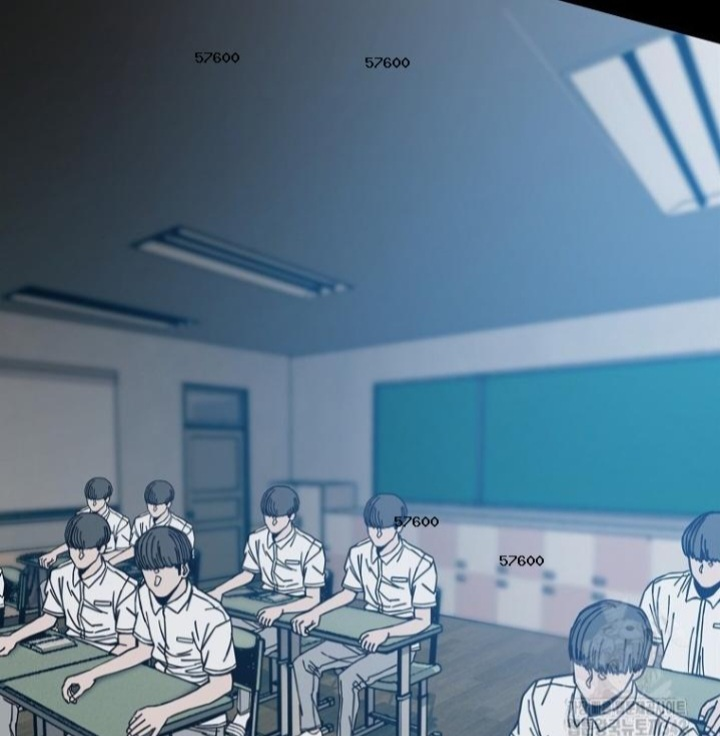

In [416]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import os

test_img = "D:/Projects/WR-comic/tmp/client_ann/Cmanga/raw/2_(94).jpg"
# test_img = "D:/Projects/WR-comic/tmp/client_ann/G5/raw/b_(92).jpg"
# test_img = "D:/Projects/WR-comic/tmp/client_ann/vlog/raw/a_(95).jpg"
# test_img = os.path.join("./data/manhua_ds/val/image/", os.listdir("./data/manhua_ds/val/image/")[5])
# test_img = os.path.join("./data/manhua_ds/train/image/", os.listdir("./data/manhua_ds/train/image/")[5000])
img = Image.open(test_img).convert("RGB")
img

In [420]:
import time

width, height = img.size
segments, positions = split_segments(img)

refine_segments = []
reconstructed_segments = []
masks = []
for seg in segments:
    seg = trans(seg)
    batch = seg.unsqueeze(0)

    [refine, reconstructed_image], reconstructed_mask, reconstructed_vm = model(batch)

    out = refine.detach().cpu().numpy()[0]
    out = np.clip(out, 0, 1)
    out = out.transpose(1, 2, 0)
    out = (out * 255).astype(np.uint8)
    out = Image.fromarray(out)
    refine_segments.append(out)

    out = reconstructed_image.detach().cpu().numpy()[0]
    out = np.clip(out, 0, 1)
    out = out.transpose(1, 2, 0)
    out = (out * 255).astype(np.uint8)
    out = Image.fromarray(out)
    reconstructed_segments.append(out)

    mask = reconstructed_mask.detach().cpu().numpy()[0][0]
    mask = np.array(mask)
    mask = (mask * 255).astype(np.uint8)
    mask = Image.fromarray(mask)
    masks.append(mask)

img_refine = reconstruct_image(refine_segments, positions, width, height)
img_reconstructed = reconstruct_image(reconstructed_segments, positions, width, height)
mask2 = reconstruct_image(masks, positions, width, height, mode="L")


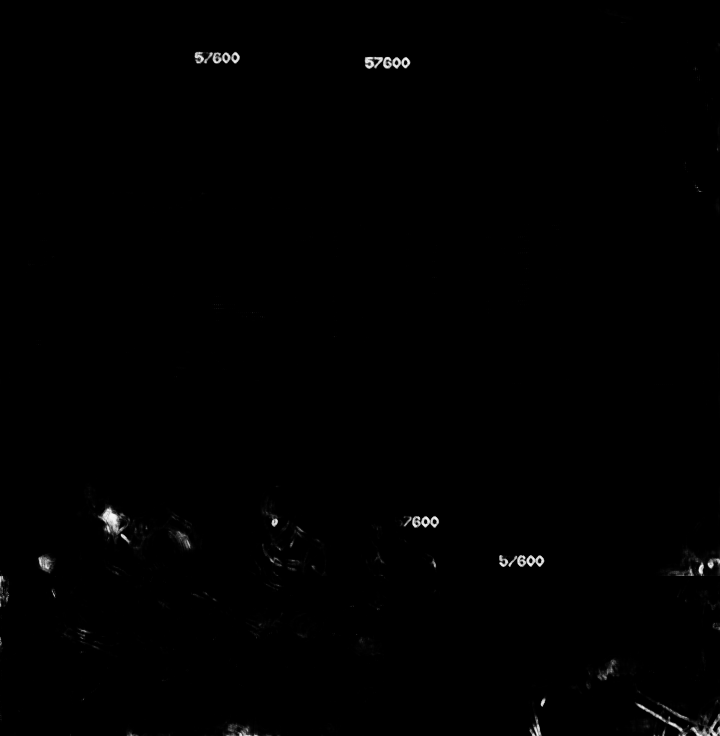

In [425]:

# img_reconstructed
mask2

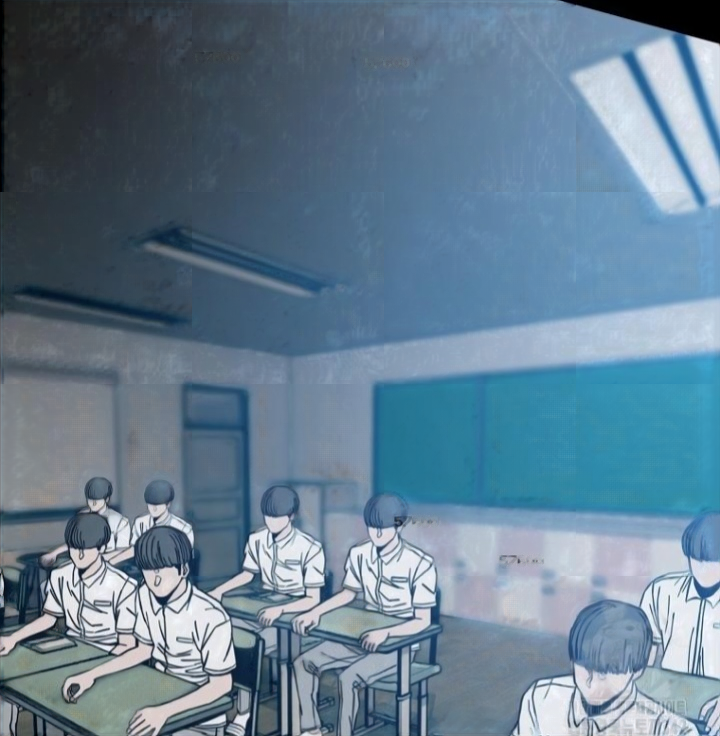

In [424]:
img2